# Find periodic variables in ComCam data

# NOTES

- Use magnitude columns
- Try diaObjects
- S/N > 10
- VSX cross-match?

## Installation

In [1]:
# %pip install lsdb dask nested-dask astropy light-curve

In [1]:
import lsdb
lsdb.__version__

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


'0.4.5.dev12+g93c26b7'

In [2]:
import pandas as pd
pd.__version__

'2.2.3'

In [3]:
from pathlib import Path

release = 'w_2025_04'
hats_path = Path("/sdf/data/rubin/shared/lsdb_commissioning/DASH/") / release / "hats"
# list dir
print(list(map(str, hats_path.iterdir())))

comcam_obj = hats_path / "object"
comcam_src = hats_path / "forcedSource"

['/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/diaSource', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/source', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/diaForcedSource', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/object', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/diaObject', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/forcedSource']


## Start Dask client

In [4]:
from dask.distributed import Client

# Start with a small client
client = Client(n_workers=64, memory_limit="16GB", threads_per_worker=1)
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/scheduler-n3o6a5l3', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:15379
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:25519'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:15851'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:23039'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:9691'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:22491'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:3559'
INFO:distributed.nanny:        Start Nanny at: 'tcp:/

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 64
Total threads: 64,Total memory: 0.93 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:15379,Workers: 64
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 0.93 TiB
Comm: tcp://127.0.0.1:28077,Total threads: 1
Dashboard: http://127.0.0.1:31541/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:25519,


## Loading & Nesting Forced Sources

In [5]:
# Load the Forced Source + MJD Table
from lsdb import read_hats


obj = read_hats(
    comcam_obj,
    columns=["objectId", "coord_ra", "coord_dec"],
)
src_flat = read_hats(
    comcam_src,
    columns=[
        "objectId", 
        # "coord_ra", "coord_dec",
        "band",
        "midpointMJDTai",
        "psfFlux", "psfFluxErr", "psfFlux_flag",
        "psfMag", "psfMagErr",
        "pixelFlags_suspect", "pixelFlags_saturated", "pixelFlags_cr", "pixelFlags_bad",
        "forcedSourceId",
        "detector",
        "visit",
    ],
)
src_nested = obj.join_nested(
    src_flat,
    nested_column_name="lc",
    left_on="objectId",
    right_on="objectId",
)
src_nested

/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,objectId,coord_ra,coord_dec,lc
npartitions=161,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<band: [string], midpointMJDTai: [double..."
"Order: 7, Pixel: 544",...,...,...,...
...,...,...,...,...
"Order: 6, Pixel: 35970",...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...


## Filter out "bad" detections and select light curves with enough observations

In [6]:
# Pre-Processing

# Use just r-band data
# src_nested = src_nested.query("lc.band == 'r'").dropna(subset="lc")

# S/N >= 3
src_nested = src_nested.dropna(subset="lc.psfFlux").query(
    # "lc.psfFlux / lc.psfFluxErr >= 5.0"
    "lc.psfFlux > 5000 and lc.psfFluxErr > 0"
    " and ~lc.psfFlux_flag"
    " and ~lc.pixelFlags_suspect"
    " and ~lc.pixelFlags_saturated"
    " and ~lc.pixelFlags_cr"
    " and ~lc.pixelFlags_bad"
).dropna(subset="lc")

MIN_NOBS = 50
MIN_NOBS_BAND = 30

# Count the length of the lightcurves, and add a length filter
# from nested_dask.utils import count_nested
# src_nested = count_nested(src_nested, "lc", join=True).query(f"n_lc >= {MIN_NOBS}")
import numpy as np
src_nested = src_nested.reduce(
    lambda x: {"n_lc": np.size(x)},
    "lc.psfFlux",
    meta={"n_lc": int},
    append_columns=True,
).query(f"n_lc >= {MIN_NOBS}")

In [7]:
# Non-lazy computation
len(src_nested._ddf)

114416

## Running Lomb-Scargle
Use light-curve package or astropy

In [76]:
import light_curve as licu
import numpy as np
from astropy.timeseries import BoxLeastSquares, LombScargleMultiband

periodogram_extractor = licu.Periodogram(
    peaks=10,
    nyquist='average',
    # resolution=1000,
    # max_freq_factor=10,
    resolution=10000,
    max_freq_factor=1,
    fast=False,
)
reduced_chi2_extractor = licu.ReducedChi2()

MAX_PERIOD = 30  # days
MIN_PERIOD = 1 / 24
BAD_PERIODS = np.array([1/3, 0.5, 2/3, 1, 2, 29.5])
# BAD_PERIODS = np.array([])
BAD_PERIOD_REL_RANGE = 10 / 365.2422

def filter_periods(periods):
    periods = np.asarray(periods)
    return (
        np.all(np.abs(periods[:, None]/BAD_PERIODS - 1.0) > BAD_PERIOD_REL_RANGE, axis=1)
        & (periods >= MIN_PERIOD) 
        & (periods <= MAX_PERIOD)
    )

BANDS = 'gri'


def extract_period_multiband_licu(band, t, flux, fluxerr, **kwargs):
    # We offset date, so we still would have <1 second precision

    _, sort_index = np.unique(t, return_index=True)
    band, t, flux, fluxerr = band[sort_index], t[sort_index], flux[sort_index], fluxerr[sort_index]
    mag = -2.5 * np.log10(flux)
    magerr = 2.5 / np.log(10) * fluxerr / flux

    band_freqs = []
    band_periodograms = []
    band_weights = []
    periods = []
    s2n = []
    for b in BANDS:
        band_idx = band == b

        # At least few points in the band
        if np.count_nonzero(band_idx) < MIN_NOBS_BAND:
            continue
        
        band_t = t[band_idx]
        band_mag = mag[band_idx]
        band_magerr = magerr[band_idx]

        freq, periodogram = periodogram_extractor.freq_power(band_t, band_mag)
        freq_idx = filter_periods(2*np.pi / freq)
        if not np.any(freq_idx):
            continue
        band_freqs.append(freq[freq_idx])
        band_periodograms.append(periodogram[freq_idx])

        reduced_chi2 = reduced_chi2_extractor(band_t, band_mag, band_magerr, **kwargs)[0]
        chi2 = reduced_chi2 * (len(band_t) - 1)
        band_weights.append(chi2)

        idx_band_period = np.argmax(band_periodograms[-1])
        periods.append(2*np.pi / band_freqs[-1][idx_band_period])
        s2n.append(
            (band_periodograms[-1][idx_band_period] - np.mean(band_periodograms[-1])) / np.std(band_periodograms[-1], ddof=1)
        )

    if len(band_periodograms) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    freq = np.unique(np.concatenate(band_freqs))
    periodograms = [np.interp(freq, f, p, left=np.mean(p), right=np.mean(p)) for f, p in zip(band_freqs, band_periodograms)]
    multiband_periodogram = np.average(periodograms, weights=band_weights, axis=0)

    idx_multiband_period = np.argmax(multiband_periodogram)
    multiband_s2n = (multiband_periodogram[idx_multiband_period] - np.mean(multiband_periodogram)) / np.std(multiband_periodogram, ddof=1)
    multiband_period = 2*np.pi / freq[idx_multiband_period]

    periods.append(multiband_period)
    s2n.append(multiband_s2n)

    best_period = periods[np.argmax(s2n)]
    best_s2n = s2n[np.argmax(s2n)]

    # Return the features as a dictionary
    return {"period_0": best_period, "period_s_to_n_0": best_s2n}





def extract_period_rband_licu(band, t, flux, fluxerr, **kwargs):
    del fluxerr  # unused

    _, sort_index = np.unique(t, return_index=True)
    band, t, flux = band[sort_index], t[sort_index], flux[sort_index]

    r_band = band == 'r'
    t, flux = t[r_band], flux[r_band]
    
    if len(t) < MIN_NOBS_BAND:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    mag = -2.5 * np.log10(flux)

    features = periodogram_extractor(t, mag, **kwargs)
    periods, s2n = features[::2], features[1::2]
    
    idx_periods = filter_periods(periods)
    if not np.any(idx_periods):
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    best_period = periods[idx_periods][0]
    best_s2n = s2n[idx_periods][0]

    return {"period_0": best_period, "period_s_to_n_0": best_s2n}


def extract_period_multiband_astropy(band, t, flux, fluxerr, **kwargs):
    del kwargs  # unused

    mag = -2.5 * np.log10(flux)
    magerr = 2.5 / np.log(10) * fluxerr / flux
    freq, power = LombScargleMultiband(t, mag, band, magerr).autopower()
    
    freq_idx = filter_periods(1 / freq)
    freq, power = freq[freq_idx], power[freq_idx]
    
    if len(freq) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    idx_period = np.argmax(power)
    period = 1 / freq[idx_period]
    s2n = (power[idx_period] - np.mean(power[idx_period])) / np.std(power[idx_period], ddof=1)
    return {"period_0": period, "period_s_to_n_0": s2n}


def extract_period_rband_box_astropy(band, t, flux, fluxerr, **kwargs):
    del kwargs  # unused

    r_band = band == 'r'
    t, flux, fluxerr = t[r_band], flux[r_band], fluxerr[r_band]
    
    # Not enough points in the light curve
    if len(t) < MIN_NOBS_BAND:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    # Light curve is too short
    if np.ptp(t) <= 2.0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    input_period = filter_periods(np.geomspace(2.0, MAX_PERIOD, 10))
    result = BoxLeastSquares(t, flux, fluxerr).autopower(
        duration=np.geomspace(1.0 / (24 * 60), 1.0, 10),
    )

    idx_period = np.argmax(result.power)
    return {"period_0": result.period[idx_period], "period_s_to_n_0": (result.power[idx_period] - np.mean(result.power[idx_period])) / np.std(result.power, ddof=1)}



In [80]:
def extract_period_singleband_licu(band, t, mag, magerr, **kwargs):
    
    
    # del magerr  # unused

    _, sort_index = np.unique(t, return_index=True)
    band, t, mag = band[sort_index], t[sort_index], mag[sort_index]

    
    BANDS = 'gri'
    periods = []
    s2n = []
    for b in BANDS:
        band_index = band == b
        band_t, band_mag = t[band_index], mag[band_index]

        if len(band_t) < MIN_NOBS_BAND:
            continue
        if np.std(band_mag) <0.15:
            continue
        print(np.std(band_mag))
        features = periodogram_extractor(band_t, band_mag, **kwargs)
        periods.extend(features[::2])
        s2n.extend(features[1::2])
    periods, s2n = np.asarray(periods), np.asarray(s2n)
    
    if len(periods) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}
    
    idx_periods = filter_periods(periods)
    if not np.any(idx_periods):
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}
    periods_inrange, s2n_inrange = periods[idx_periods], s2n[idx_periods]
    
    idx_best_period = np.argmax(s2n_inrange)
    best_period = periods_inrange[idx_best_period]
    best_s2n = s2n_inrange[idx_best_period]

    return {"period_0": best_period, "period_s_to_n_0": best_s2n}

In [79]:

src_nested_w_features = src_nested.reduce(
    extract_period_singleband_licu,
    "lc.band",
    "lc.midpointMJDTai",
    "lc.psfMag",
    "lc.psfMagErr",
    meta={"period_0": float, "period_s_to_n_0": float},
    append_columns=True,
)

In [29]:
src_nested

,objectId,coord_ra,coord_dec,lc,n_lc
npartitions=161,,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<band: [string], midpointMJDTai: [double...",int64
"Order: 7, Pixel: 544",...,...,...,...,...
...,...,...,...,...,...
"Order: 6, Pixel: 35970",...,...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...,...


## Periodic Candidate Selection

In [21]:
%%time
# Look for periods around half a day, select for high periodogram S/N
src_nested_periodic_cand = src_nested_w_features.query(
    "period_s_to_n_0 > 4"
)

CPU times: user 7.47 ms, sys: 1.58 ms, total: 9.05 ms
Wall time: 8.14 ms


In [22]:
# len(src_nested_periodic_cand)

## Plotting a few Phase-Folded Candidates

In [23]:
cand_subset = src_nested_periodic_cand.compute()
cand_subset = cand_subset.sort_values(by="period_s_to_n_0", ascending=False)
cand_subset

2025-01-29 18:40:31,752 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:1417
Traceback (most recent call last):
  File "/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/distributed/utils.py", line 1910, in wait_for
    return await fut
           ^^^^^^^^^
  File "/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/distributed/comm/tcp.py", line 546, in connect
    stream = await self.client.connect(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/tornado/tcpclient.py", line 279, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/distributed/comm/core.py", line 342, in connect
    c

,objectId,coord_ra,coord_dec,lc,n_lc,period_0,period_s_to_n_0
_healpix_29,,,,,,,
2528716925405848452,2226788123176601419,53.304617,-28.121906,band midpointMJDTai psfFlux psfFl...,469,1.130618,5.618493
2528738974747670930,2226796919269637092,52.955366,-28.108115,band midpointMJDTai psfFlux psfFlux...,447,1.128212,5.565964
2528742960735213328,2226836501688236462,53.238006,-27.9603,band midpointMJDTai psfFlux psfF...,633,1.131887,5.498965
2528750028609442826,2226836501688244218,53.086321,-27.86176,band midpointMJDTai psfFlux psfFl...,466,1.131533,5.431467
2528694158197781435,2226761734897535917,52.649874,-28.242626,band midpointMJDTai psfFlux psfFlu...,169,6.813790,5.405461
...,...,...,...,...,...,...,...
2528713603973509408,2226748540758020774,53.196295,-28.226441,band midpointMJDTai psfFlux psfFlu...,457,1.189653,4.002527
2528708561508303395,2133034965699397767,53.608151,-28.26588,band midpointMJDTai psfFlux psfFlu...,190,1.127536,4.002385
2528742981578986945,2226836501688236461,53.228641,-27.962497,band midpointMJDTai psfFlux psfF...,683,0.609744,4.001634


In [28]:
cand_subset[cand_subset['objectId'].values == 2430400084454684424]

,objectId,coord_ra,coord_dec,lc,n_lc,period_0,period_s_to_n_0
_healpix_29,,,,,,,


2226788123176601419
2226796919269637092
2226836501688236462
2226836501688244218
2226761734897535917
2226744142711505147
2133039363745921441
2226836501688241166
2226796919269621972
2133048159838932738
2226796919269639125
2226748540758003045
2226788123176615262
2226792521223126284
2132568772769222443
2226840899734753869
2226796919269638076
2226744142711511306
2226748540758003853
2132577568862243413


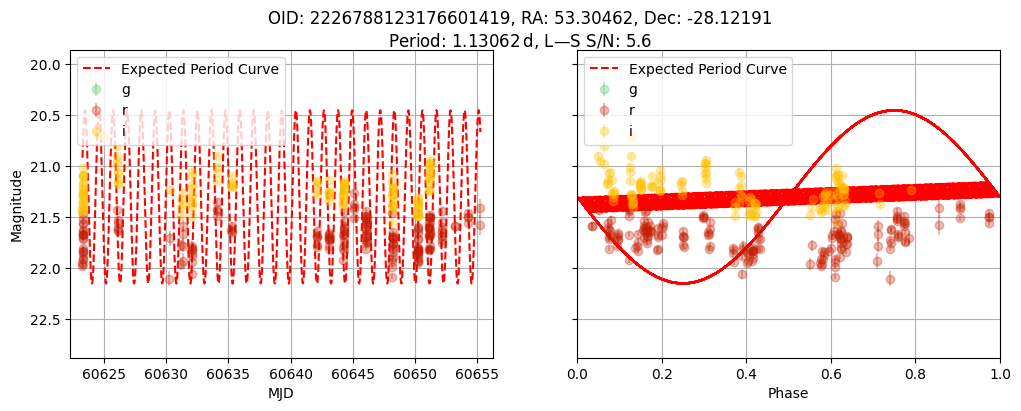

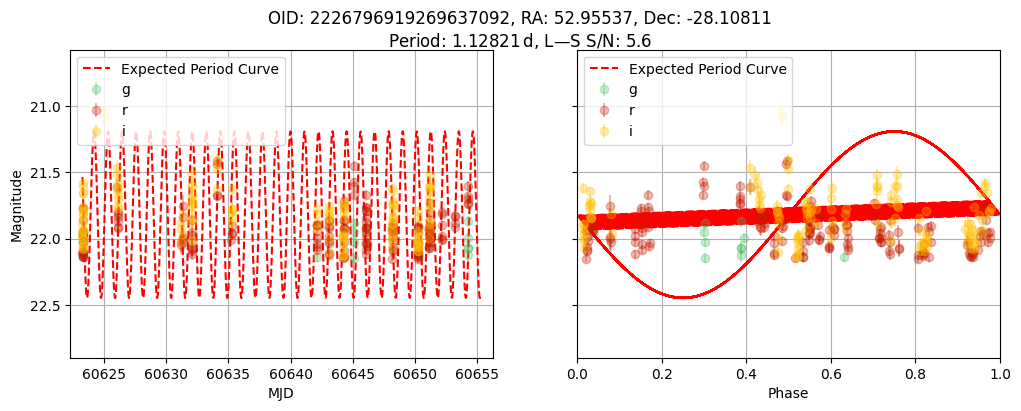

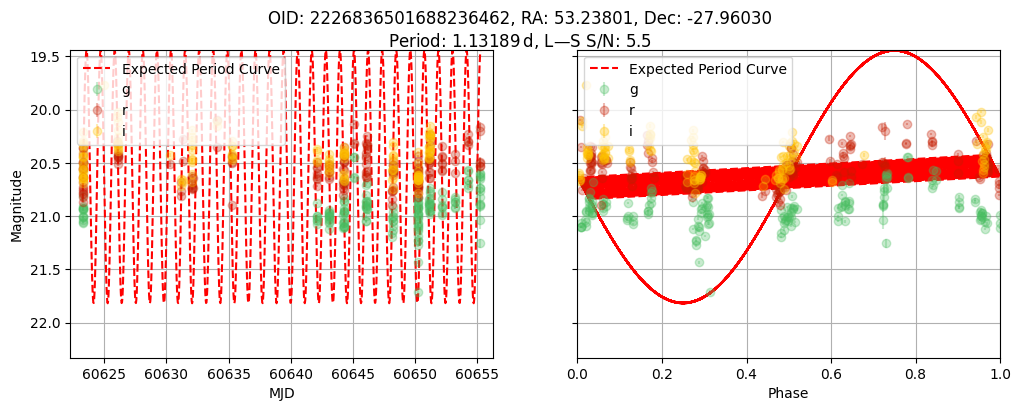

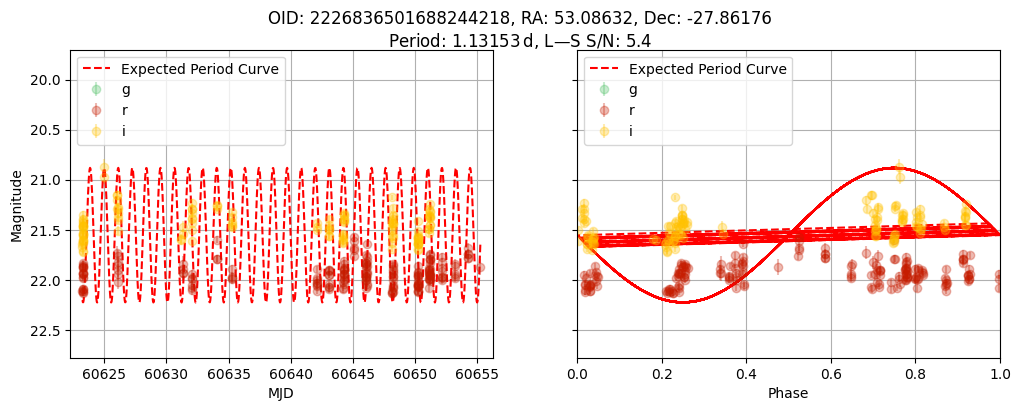

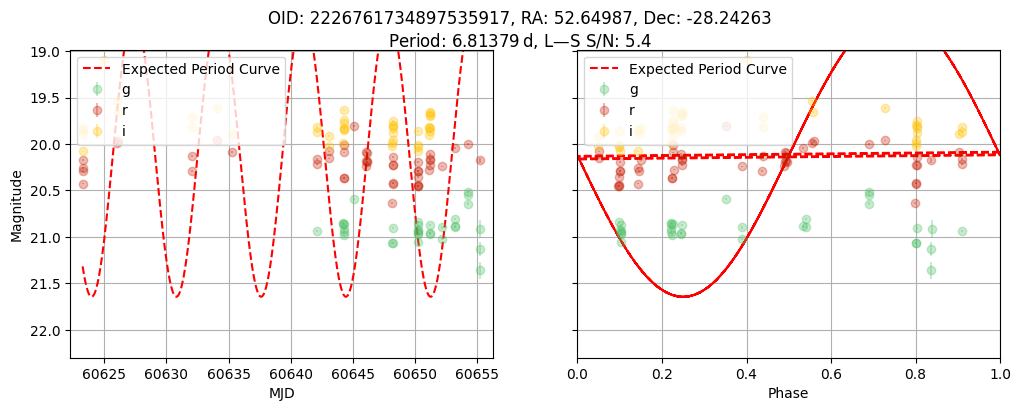

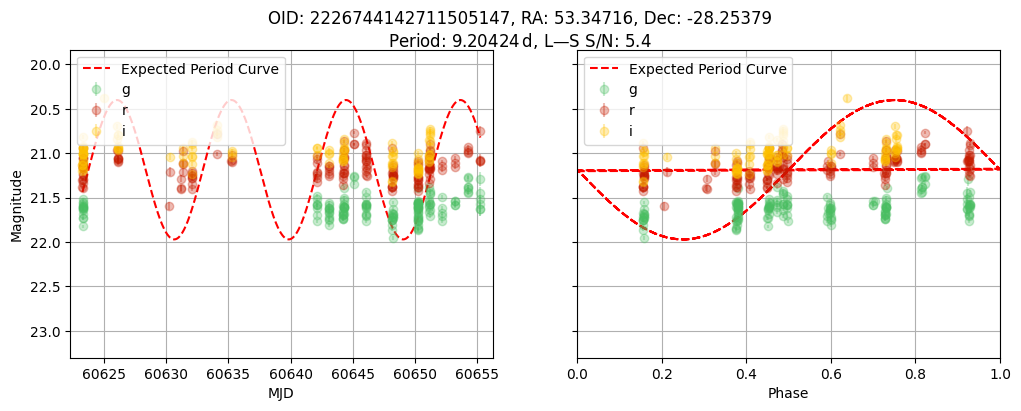

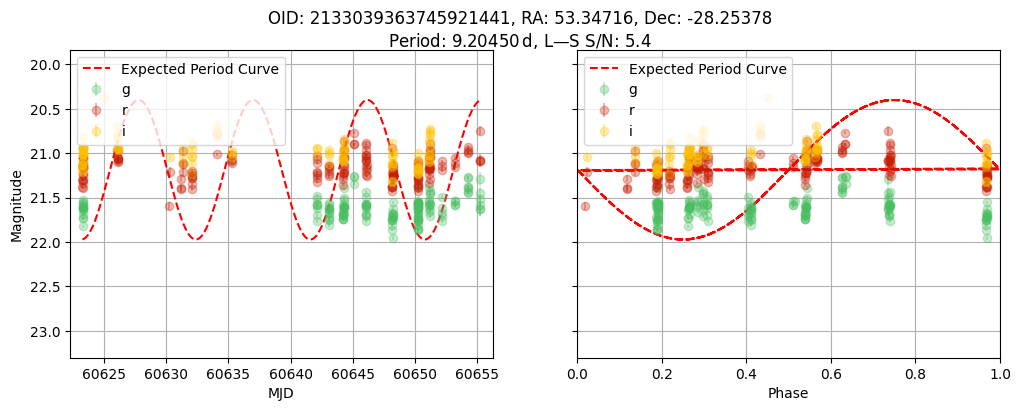

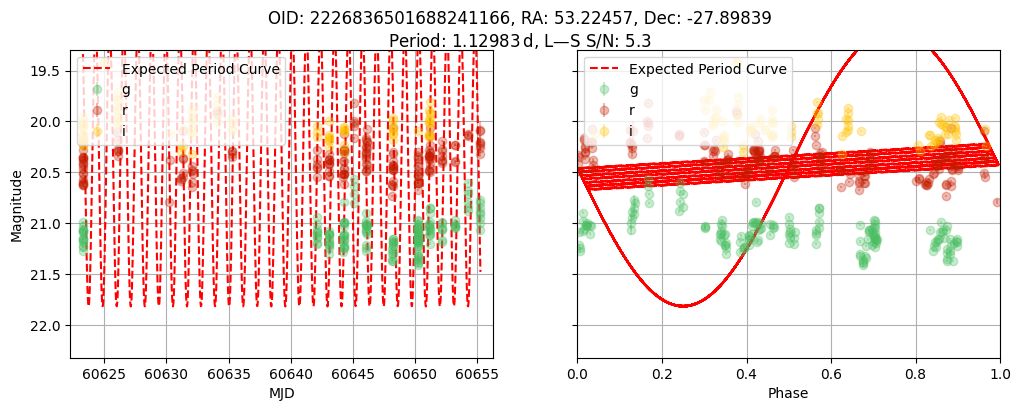

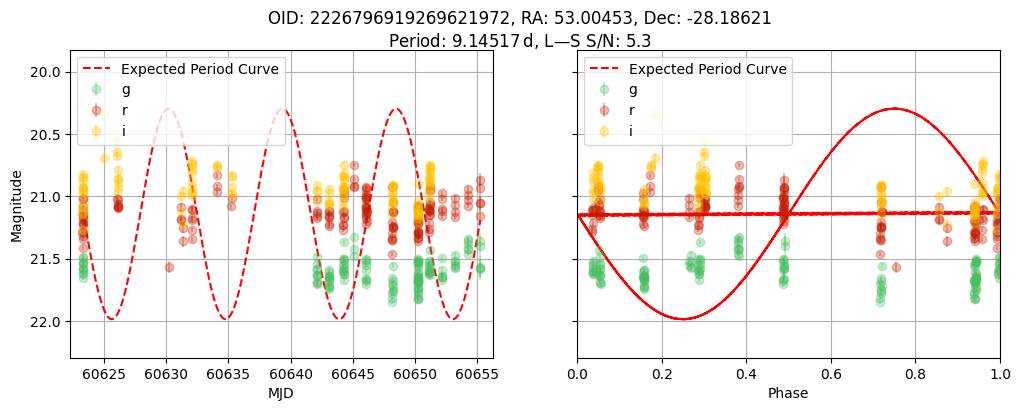

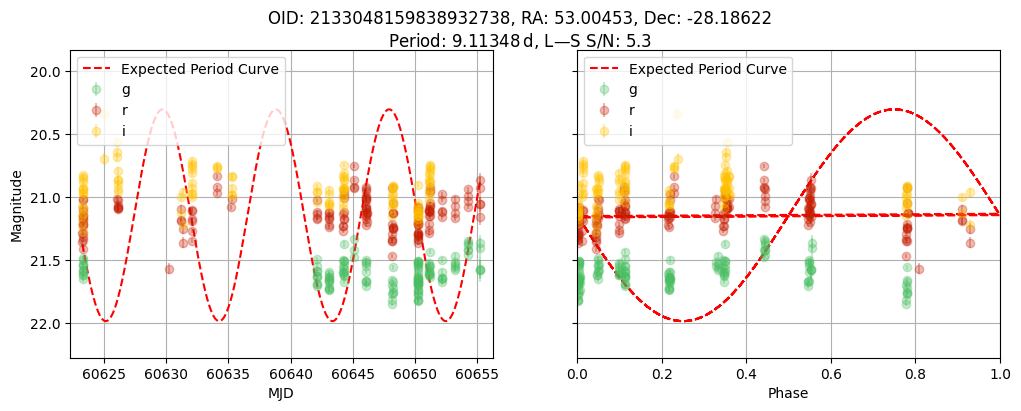

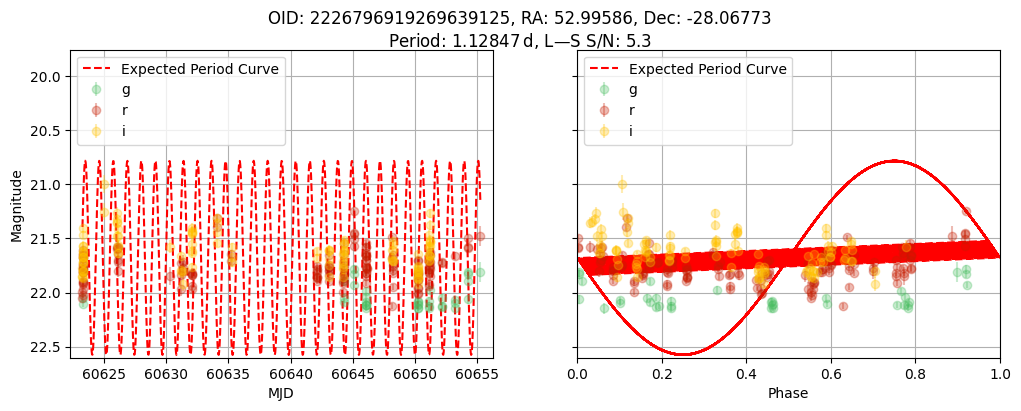

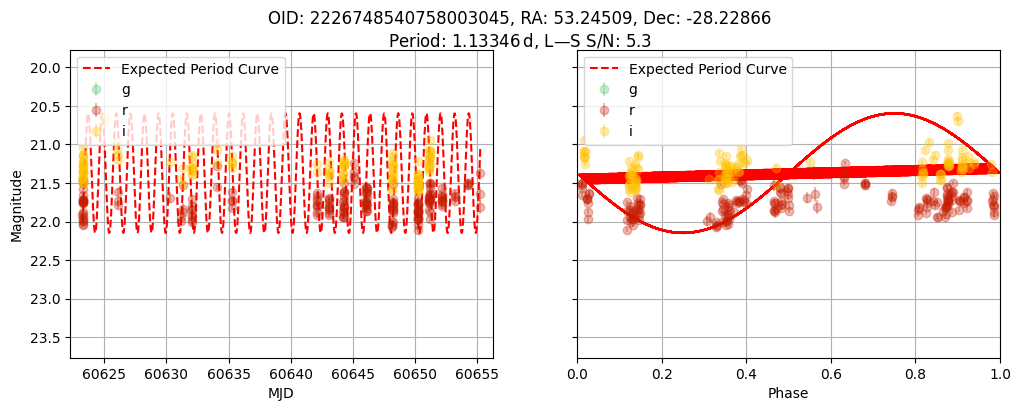

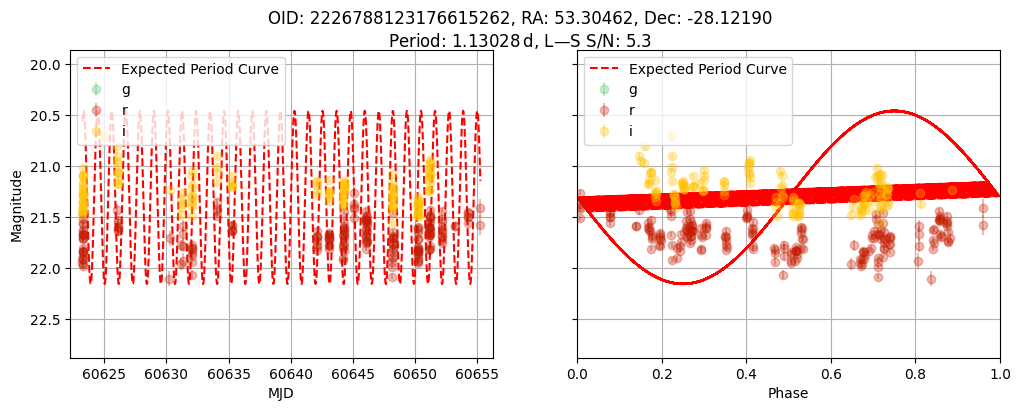

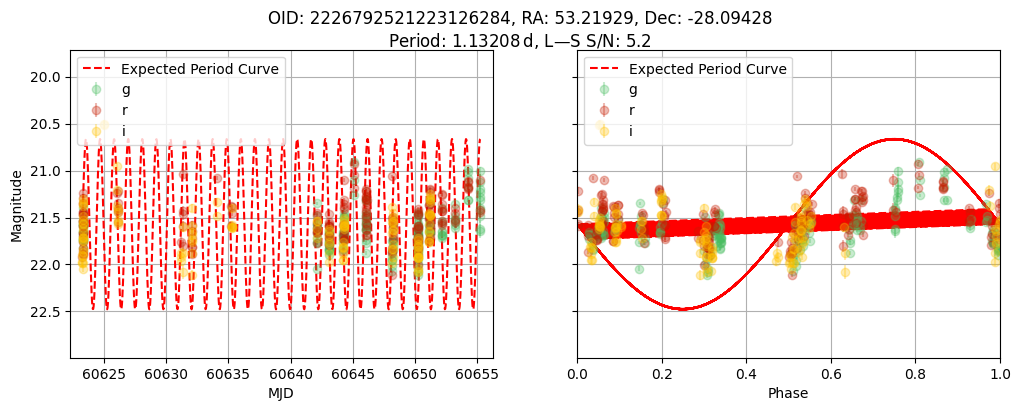

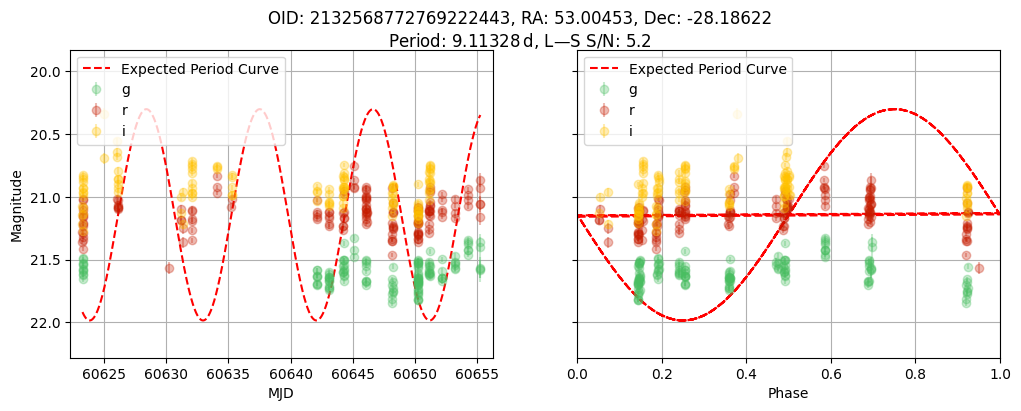

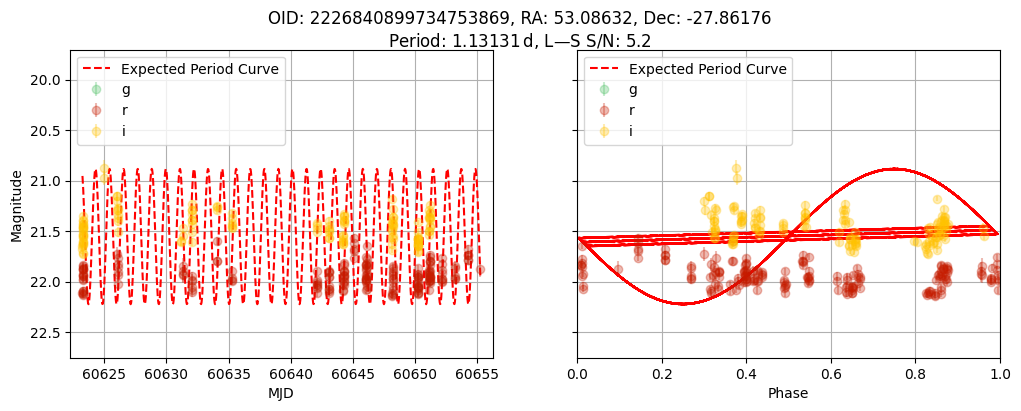

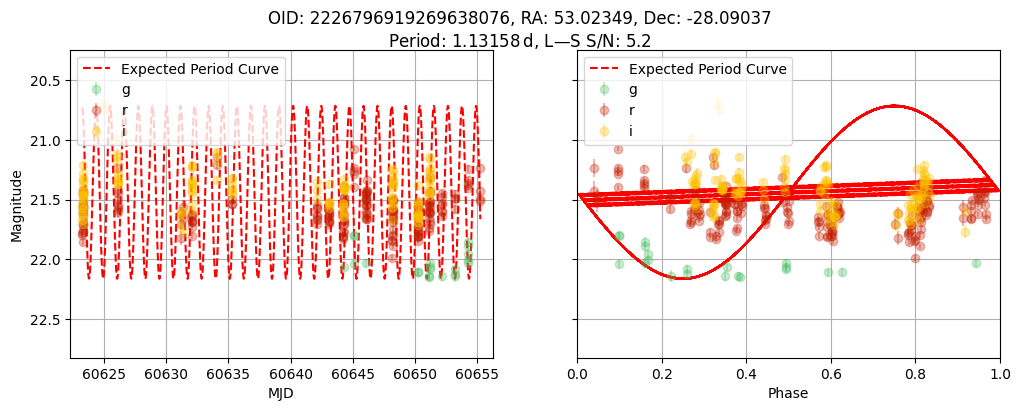

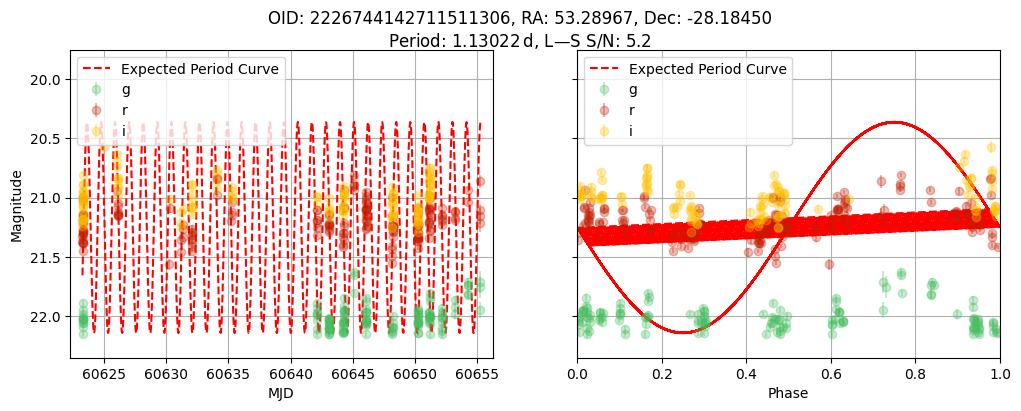

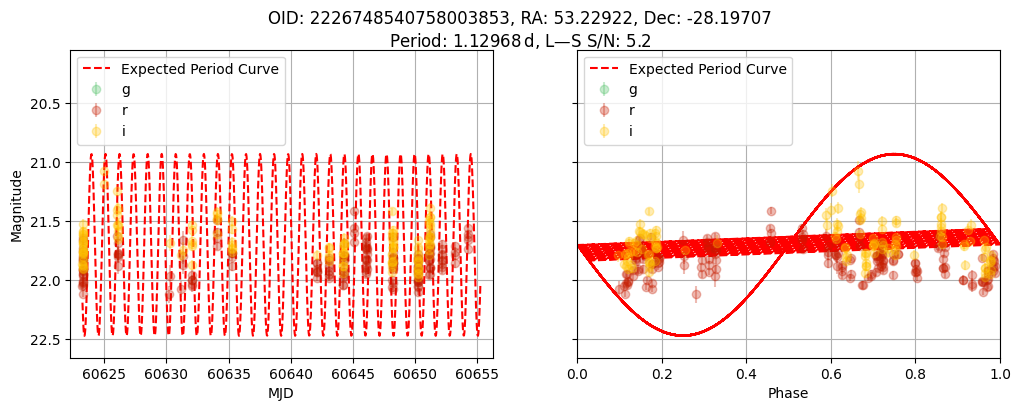

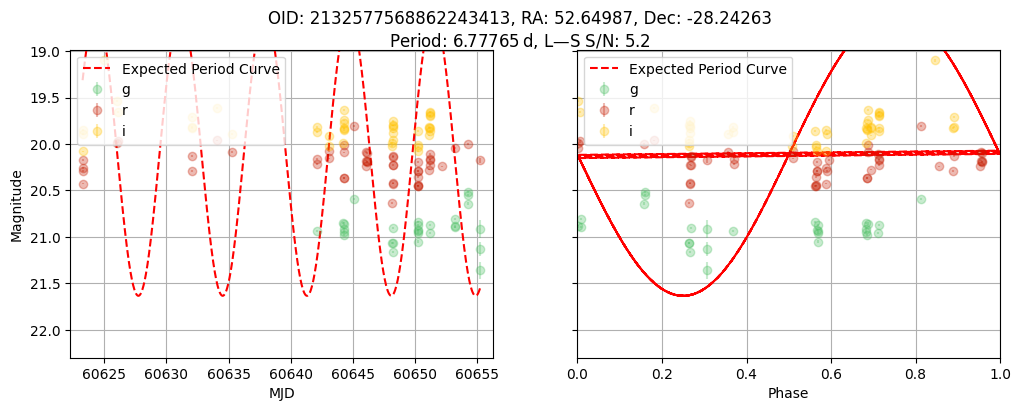

In [24]:
COLORS = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00',
          'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

FOLDED = True

for healpix29, cand in cand_subset.iloc[:20].iterrows():
    phase = cand.lc["midpointMJDTai"] % cand["period_0"] / cand["period_0"]
    mag = -2.5 * np.log10(cand.lc["psfFlux"]) + 31.4
    magerr = 2.5 / np.log(10) * cand.lc["psfFluxErr"] / cand.lc["psfFlux"]
    
    fig, (ax_mjd, ax_phase) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    # Plot data for each band
    for b in BANDS:
        idx = (cand.lc["band"] == b) & (magerr < 0.1)
        errorbar_kwargs = dict(
            y=mag[idx],  # Use actual magnitudes
            yerr=magerr[idx],
            fmt="o",
            color=COLORS[b],
            label=f'{b}',  # Label only the band
            alpha=0.3,
        )
        ax_mjd.errorbar(cand.lc["midpointMJDTai"][idx], **errorbar_kwargs)
        ax_phase.errorbar(phase[idx], **errorbar_kwargs)
    
    # Calculate and overplot the expected period curve
    # Generate time points for the expected curve
    time_curve = np.linspace(np.min(cand.lc["midpointMJDTai"]), 
                             np.max(cand.lc["midpointMJDTai"]), 1000)
    # Calculate the phase for the curve
    phase_curve = (time_curve % cand["period_0"]) / cand["period_0"]
    
    # Example: Use a sinusoidal model for the expected period curve
    expected_magnitude_curve = np.sin(2 * np.pi * phase_curve)  # Scaled to match variability
    expected_magnitude_curve = (
        np.mean(mag) + (np.max(mag) - np.min(mag)) / 2 * expected_magnitude_curve
    )  # Scale to match observed magnitudes
    
    # Overplot the curve on the left-hand side
    ax_mjd.plot(time_curve, expected_magnitude_curve, color='red', linestyle='--', label='Expected Period Curve')

    # Overplot the same curve on the phase-folded plot
    ax_phase.plot(phase_curve, expected_magnitude_curve, color='red', linestyle='--', label='Expected Period Curve')

    # Add titles, labels, and legends
    fig.suptitle(
        f"OID: {cand.objectId}, RA: {cand['coord_ra']:.5f}, Dec: {cand['coord_dec']:.5f}"
        f"\nPeriod: {cand['period_0']:.5f}$\,$d, L—S S/N: {cand['period_s_to_n_0']:.1f}"
    )
    ax_mjd.set_ylabel("Magnitude")  # Updated label to reflect actual magnitudes
    ax_mjd.set_xlabel("MJD")
    ax_mjd.set_xlim(np.min(cand.lc["midpointMJDTai"])-1, np.max(cand.lc["midpointMJDTai"])+1)
    ax_phase.set_xlabel("Phase")
    ax_phase.set_xlim(0, 1)

    # Adjust y-axis limits
    ymin, ymax = np.min(mag - magerr), np.max(mag + magerr)
    plt.ylim(ymin - 0.1, ymax + 0.1)
    plt.gca().invert_yaxis()
    
    ax_mjd.legend(loc='upper left')
    ax_phase.legend(loc='upper left')
    ax_mjd.grid()
    ax_phase.grid()
    
    plt.savefig(f"periodic_cand-{release}-{cand.objectId}.pdf")
    print(cand.objectId)

### Potentially Interesting Candidates
2226748540758018644, 2226840899734749849, 2226796919269630775

In [30]:
OID = 2430400084454684424

In [31]:
filters = [("objectId", "==", OID)]

obj = read_hats(
    comcam_obj,
    columns=["objectId", "coord_ra", "coord_dec"],
    filters=filters,
)
src_flat = read_hats(
    comcam_src,
    # columns=[
    #     "objectId", 
    #     "coord_ra", "coord_dec",
    #     "band",
    #     "midpointMJDTai",
    #     "psfFlux", "psfFluxErr", "psfFlux_flag",
    #     "forcedSourceId",
    #     "detector",
    #     "visit",
    # ],
    filters=filters,
)
src_nested = obj.join_nested(
    src_flat,
    nested_column_name="lc",
    left_on="objectId",
    right_on="objectId",
)
src_nested

/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,objectId,coord_ra,coord_dec,lc
npartitions=161,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<forcedSourceId: [int64], parentObjectId..."
"Order: 7, Pixel: 544",...,...,...,...
...,...,...,...,...
"Order: 6, Pixel: 35970",...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...


In [38]:
import pandas as pd; pd.set_option('display.max_columns', None)
ndf = src_nested.compute()
ndf = ndf.query(
    "~lc.psfFlux_flag"
    " and ~lc.pixelFlags_suspect"
    " and ~lc.pixelFlags_saturated"
    " and ~lc.pixelFlags_cr"
    " and ~lc.pixelFlags_bad"
)
display(ndf)
data = ndf.iloc[0]
display(data)
data.lc.sort_values("midpointMJDTai")

,objectId,coord_ra,coord_dec,lc
_healpix_29,,,,
1456140633585051096,2430400084454684424,94.922636,-25.231852,forcedSourceId parentObjectId coor...


objectId                                   2430400084454684424
coord_ra                                             94.922636
coord_dec                                           -25.231852
lc                    forcedSourceId  parentObjectId   coor...
Name: 1456140633585051096, dtype: object

,forcedSourceId,parentObjectId,coord_ra,coord_dec,visit,detector,band,psfFlux,psfFluxErr,psfFlux_flag,psfDiffFlux,psfDiffFluxErr,psfDiffFlux_flag,localPhotoCalib,localPhotoCalib_flag,localPhotoCalibErr,localWcs_flag,localWcs_CDMatrix_2_1,localWcs_CDMatrix_1_1,localWcs_CDMatrix_1_2,localWcs_CDMatrix_2_2,localBackground_instFlux,localBackground_instFluxErr,pixelFlags_edge,pixelFlags_interpolated,pixelFlags_saturated,pixelFlags_cr,pixelFlags_bad,pixelFlags_suspect,pixelFlags_interpolatedCenter,pixelFlags_saturatedCenter,pixelFlags_crCenter,pixelFlags_suspectCenter,invalidPsfFlag,tract,patch,detect_isPrimary,detect_isTractInner,detect_isPatchInner,midpointMJDTai,psfMag,psfMagErr,Norder,Dir,Npix
128,191262631099646725,0,94.922636,-25.231852,2024111900358,6,y,112863.899040,1414.170583,False,10467.300279,1453.451758,False,1.0,False,0.001416,False,6.852475e-07,6.888017e-07,6.845641e-07,-6.888383e-07,25.271272,160.550532,False,False,False,False,False,False,False,False,False,False,False,5526,9,True,True,True,60634.323548,18.768612,0.013605,9,1320000,1324352
129,191262633247131071,0,94.922636,-25.231852,2024111900360,6,y,114071.406949,1368.268077,False,11383.135199,1402.958670,False,1.0,False,0.001359,False,6.882876e-07,6.855593e-07,6.877361e-07,-6.855634e-07,0.018706,165.499625,False,False,False,False,False,False,False,False,False,False,False,5526,9,True,True,True,60634.324786,18.757058,0.013024,9,1320000,1324352
17,191262634308277416,0,94.922636,-25.231852,2024111900361,3,y,110788.074585,1365.805181,False,2677.981129,1403.917084,False,1.0,False,0.001609,False,6.913254e-07,6.822721e-07,6.909055e-07,-6.822642e-07,0.602551,159.991318,False,False,False,False,False,False,False,False,False,False,False,5526,9,True,True,True,60634.325417,18.788767,0.013386,9,1320000,1324352
169,191262635398800788,0,94.922636,-25.231852,2024111900362,7,y,109485.640237,1415.599150,False,6758.866791,1447.568872,False,1.0,False,0.001582,False,6.997987e-07,6.731807e-07,6.997405e-07,-6.735318e-07,2.981046,173.773718,False,False,False,False,False,False,False,False,False,False,False,5526,9,True,True,True,60634.326023,18.801607,0.014039,9,1320000,1324352
18,191262636455760781,0,94.922636,-25.231852,2024111900363,3,y,110606.204023,1352.004734,False,2969.941493,1394.508755,False,1.0,False,0.001369,False,6.881301e-07,6.857645e-07,6.876627e-07,-6.856560e-07,1.238975,163.511688,False,False,False,False,False,False,False,False,False,False,False,5526,9,True,True,True,60634.326705,18.790551,0.013272,9,1320000,1324352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,192036928864917936,0,94.922636,-25.231852,2024121100583,3,r,135792.328136,405.842189,False,-749.079656,408.913810,False,1.0,False,0.000206,False,6.984150e-07,6.745280e-07,6.981864e-07,-6.746767e-07,3.849129,19.204037,False,False,False,False,False,False,False,False,False,False,False,5526,9,True,True,True,60656.340274,18.567812,0.003245,9,1320000,1324352
166,192036929951240998,0,94.922636,-25.231852,2024121100584,6,r,134849.970446,401.992810,False,-1597.975134,407.853635,False,1.0,False,0.000185,False,6.951735e-07,6.787248e-07,6.949084e-07,-6.796079e-07,3.912051,19.262211,False,False,False,False,False,False,False,False,False,False,False,5526,9,True,True,True,60656.340666,18.575373,0.003237,9,1320000,1324352
119,192036931016597592,0,94.922636,-25.231852,2024121100585,4,r,133940.442150,400.660167,False,-2495.943270,406.155937,False,1.0,False,0.000205,False,6.998312e-07,6.728956e-07,6.999104e-07,-6.729431e-07,2.401667,19.238927,False,False,False,False,False,False,False,False,False,False,False,5526,9,True,True,True,60656.341097,18.582721,0.003248,9,1320000,1324352
167,192036932098736862,0,94.922636,-25.231852,2024121100586,6,r,133314.123279,397.294158,False,-3298.171571,402.039693,False,1.0,False,0.000182,False,6.962701e-07,6.772949e-07,6.958425e-07,-6.772850e-07,2.732694,19.000521,False

In [39]:
cand = data

In [47]:
cand["period_0"] = 1.84/24

cand['period_s_to_n_0'] = 5.0

In [49]:
b = 'r'
idx = (cand.lc["band"] == b) & (magerr < 0.1)
errorbar_kwargs = dict(
    y=mag[idx],  # Use actual magnitudes
    yerr=magerr[idx],
    fmt="o",
    color=COLORS[b],
    label=f'{b}',  # Label only the band
    alpha=0.3,
)
ax_mjd.errorbar(cand.lc["midpointMJDTai"][idx], **errorbar_kwargs)
ax_phase.errorbar(phase[idx], **errorbar_kwargs)


<ErrorbarContainer object of 3 artists>

2430400084454684424


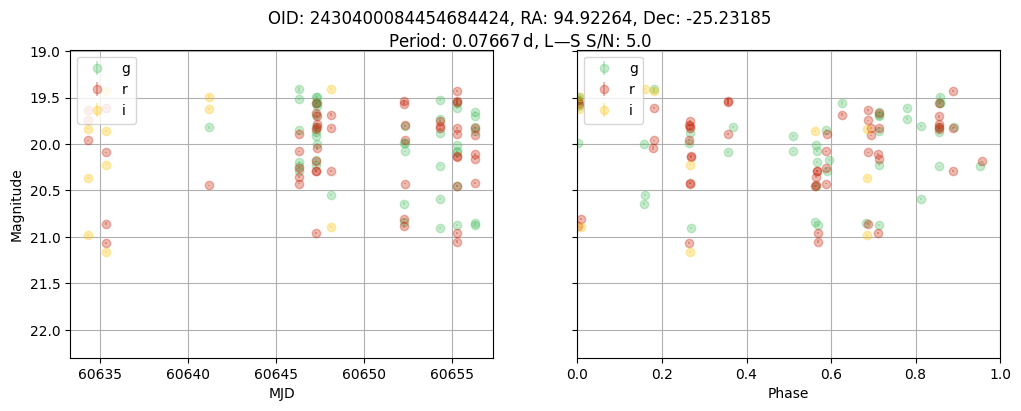

In [51]:
fig, (ax_mjd, ax_phase) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
# Plot data for each band
for b in BANDS:
    idx = (cand.lc["band"] == b) & (magerr < 0.1)
    errorbar_kwargs = dict(
        y=mag[idx],  # Use actual magnitudes
        yerr=magerr[idx],
        fmt="o",
        color=COLORS[b],
        label=f'{b}',  # Label only the band
        alpha=0.3,
    )
    ax_mjd.errorbar(cand.lc["midpointMJDTai"][idx], **errorbar_kwargs)
    ax_phase.errorbar(phase[idx], **errorbar_kwargs)

# Calculate and overplot the expected period curve
# Generate time points for the expected curve
time_curve = np.linspace(np.min(cand.lc["midpointMJDTai"]), 
                            np.max(cand.lc["midpointMJDTai"]), 1000)
# Calculate the phase for the curve
phase_curve = (time_curve % cand["period_0"]) / cand["period_0"]

# Example: Use a sinusoidal model for the expected period curve
expected_magnitude_curve = np.sin(2 * np.pi * phase_curve)  # Scaled to match variability
expected_magnitude_curve = (
    np.mean(mag) + (np.max(mag) - np.min(mag)) / 2 * expected_magnitude_curve
)  # Scale to match observed magnitudes

# Overplot the curve on the left-hand side
# ax_mjd.plot(time_curve, expected_magnitude_curve, color='red', linestyle='--', label='Expected Period Curve')

# Overplot the same curve on the phase-folded plot
# ax_phase.plot(phase_curve, expected_magnitude_curve, color='red', linestyle='--', label='Expected Period Curve')

# Add titles, labels, and legends
fig.suptitle(
    f"OID: {cand.objectId}, RA: {cand['coord_ra']:.5f}, Dec: {cand['coord_dec']:.5f}"
    f"\nPeriod: {cand['period_0']:.5f}$\,$d, L—S S/N: {cand['period_s_to_n_0']:.1f}"
)
ax_mjd.set_ylabel("Magnitude")  # Updated label to reflect actual magnitudes
ax_mjd.set_xlabel("MJD")
ax_mjd.set_xlim(np.min(cand.lc["midpointMJDTai"])-1, np.max(cand.lc["midpointMJDTai"])+1)
ax_phase.set_xlabel("Phase")
ax_phase.set_xlim(0, 1)

# Adjust y-axis limits
ymin, ymax = np.min(mag - magerr), np.max(mag + magerr)
plt.ylim(ymin - 0.1, ymax + 0.1)
plt.gca().invert_yaxis()

ax_mjd.legend(loc='upper left')
ax_phase.legend(loc='upper left')
ax_mjd.grid()
ax_phase.grid()

plt.savefig(f"periodic_cand-{release}-{cand.objectId}.pdf")
print(cand.objectId)

In [60]:
band = cand.lc["band"]
t = cand.lc['midpointMJDTai']
mag = cand.lc['psfMag']

valid_idx = ~np.isnan(t) & ~np.isnan(mag)
t = t[valid_idx]
mag = mag[valid_idx]
band = band[valid_idx]

In [81]:
extract_period_singleband_licu(band, t, mag, cand.lc['psfMagErr'])


0.19743108237390178


TypeError: Unsupported dtype

In [82]:
 ??periodogram_extractor

Signature:   periodogram_extractor(*args, **kwargs)
Type:        Periodogram
String form: <light_curve.light_curve_ext.Periodogram object at 0x7f740ac96e70>
File:        ~/.local/lib/python3.11/site-packages/light_curve/light_curve_ext.py
Docstring:  
Peaks of Lomb–Scargle periodogram and periodogram as a meta-feature

Periodogram $P(\omega)$ is an estimate of spectral density of unevenly time series. `peaks` argument
corresponds to a number of the most significant spectral density peaks to return. For each peak its
period and "signal to noise" ratio is returned:

$$
\mathrm{signal~to~noise~of~peak} \equiv \frac{P(\omega_\mathrm{peak}) - \langle P(\omega) \rangle}{\sigma\_{P(\omega)}}.
$$

[Periodogram] can accept other features for feature extraction from periodogram as it was time
series without observation errors (unity weights are used if required). You can even pass one
[Periodogram] to another one if you are crazy enough

- Depends on: **time**, **magnitude**
- Minimum number of 

In [91]:
band = cand.lc["band"]
t = cand.lc['midpointMJDTai']
mag = cand.lc['psfMag']
magerr = cand.lc['psfMagErr']

valid_idx = ~np.isnan(t) & ~np.isnan(mag)
t = t[valid_idx]
mag = mag[valid_idx]
band = band[valid_idx]
magerr = magerr[valid_idx]

_, sort_index = np.unique(t, return_index=True)
band, t, mag, magerr = band[sort_index], t[sort_index], mag[sort_index], magerr[sort_index]

# Convert pandas Series to NumPy arrays with explicit dtype
t_array = np.asarray(t, dtype=np.float64)
mag_array = np.asarray(mag, dtype=np.float64)

# Remove invalid values (e.g., NaN or inf)
valid_idx = ~np.isnan(t_array) & ~np.isnan(mag_array) & np.isfinite(t_array) & np.isfinite(mag_array)
t_array = t_array[valid_idx]
mag_array = mag_array[valid_idx]

# Call the periodogram_extractor with cleaned inputs
result = periodogram_extractor(t_array, mag_array)

In [94]:
extract_period_singleband_licu(band, t_array, mag_array, cand.lc['psfMagErr'])

0.26280926416792294
0.45407999322469644


{'period_0': np.float64(0.9488117914779521),
 'period_s_to_n_0': np.float64(3.110447678563586)}

In [85]:
type(mag)

pandas.core.series.Series